### Implementing Gradient-Based Learning Applied to Document Recognition

Link: http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf

The general architecture with the Subsampling layer has been used in this implementation

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
import tensorflow as tf

from tensorflow.python.ops import nn_ops

sys.path.append("..")

from datasets.mnist import MNIST_DATASET

In [2]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

In [3]:
dataset_path = '/Users/rohit/Desktop/datasets/mnist'
x_train, y_train, x_test, y_test = MNIST_DATASET.load_dataset(dataset_path=dataset_path, reshape=True)

### Create dataloader and batch data

In [4]:
def pad_image(image, label):
    return tf.pad(image, tf.constant([[2, 2,], [2, 2]]), "CONSTANT"), label

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).map(pad_image, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(pad_image, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE)

Metal device set to: Apple M1 Pro


2023-01-16 19:11:13.480774: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-16 19:11:13.480976: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Display training and test data

Train dataset


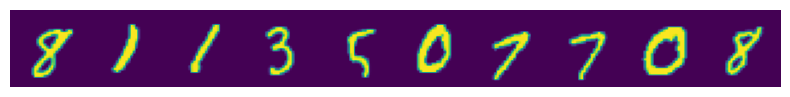

Labels: 8      1      1      3      5      0      7      7      0      8

Test dataset


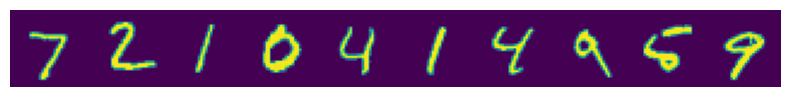

Labels: 7      2      1      0      4      1      4      9      5      9


In [79]:
def display_dataset(dataset, count=1, figsize=1):
    for x, y in dataset.take(1):
        images = None
        labels = ""
        for i in range(count):
            image = x[i].numpy()
            label = y[i].numpy()
            
            if images is None:
                images = image
                labels = str(label)
            else:
                images = np.hstack((images, image))
                labels = labels + "      " + str(label)
        
        fig = plt.figure(figsize=(figsize * count, figsize))
        plt.imshow(images)
        plt.axis('off')
        plt.show()
        print(f"Labels: {labels}")

print("Train dataset")
display_dataset(train_dataset, 10)

print("\nTest dataset")
display_dataset(test_dataset, 10)

### Build Model

<img src="../images/image1.png" alt="LeNet5" style="width:700px;"/>

In [5]:
class SubSampling2D(tf.keras.layers.Layer):
    def __init__(self, trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        super(SubSampling2D, self).__init__(trainable, name, dtype, dynamic, **kwargs)

    def build(self, input_shape):
        self.num_filters = input_shape[-1]
        
        self.kernel = self.add_weight(
                                name='kernel',
                                shape=(self.num_filters, ), 
                                initializer='glorot_uniform',
                                trainable=True)

        self.bias = self.add_weight(
                                name='bias',
                                shape=(self.num_filters, ), 
                                initializer='glorot_uniform',
                                trainable=True)

        # Using average pooling instead of sum as in the paper
        self.pool = tf.keras.layers.AveragePooling2D(pool_size=2, 
                                                     strides=2)

    def call(self, inputs, *args, **kwargs):
        output = self.pool(inputs)
        output = output * self.kernel + self.bias
        return tf.math.sigmoid(output)


In [6]:
tf.keras.backend.clear_session()

lenet5 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, padding='valid', input_shape=(32, 32, 1)),
    SubSampling2D(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=5, padding='valid'),
    SubSampling2D(),
    tf.keras.layers.Conv2D(filters=120, kernel_size=5, padding='valid', activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Reshape((10, )),
    tf.keras.layers.Softmax()
])

lenet5.build()

print(lenet5.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 sub_sampling2d (SubSampling  (None, 14, 14, 6)        12        
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 sub_sampling2d_1 (SubSampli  (None, 5, 5, 16)         32        
 ng2D)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         48120     
                                                                 
 dense (Dense)               (None, 1, 1, 84)          1

In [7]:
lenet5.compile(optimizer=tf.keras.optimizers.RMSprop(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['sparse_categorical_accuracy'])

In [8]:
lenet5.fit(train_dataset, epochs=10)

Epoch 1/10


2023-01-16 19:11:37.019888: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-16 19:11:37.469238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 17s 17ms/step - loss: 1.0014 - sparse_categorical_accuracy: 0.6458
Epoch 2/10
938/938 [==============================] - 16s 17ms/step - loss: 0.1898 - sparse_categorical_accuracy: 0.9419
Epoch 3/10
938/938 [==============================] - 16s 17ms/step - loss: 0.1189 - sparse_categorical_accuracy: 0.9627
Epoch 4/10
938/938 [==============================] - 16s 17ms/step - loss: 0.0906 - sparse_categorical_accuracy: 0.9719
Epoch 5/10
938/938 [==============================] - 16s 17ms/step - loss: 0.0765 - sparse_categorical_accuracy: 0.9764
Epoch 6/10
938/938 [==============================] - 18s 19ms/step - loss: 0.0661 - sparse_categorical_accuracy: 0.9797
Epoch 7/10
938/938 [==============================] - 17s 18ms/step - loss: 0.0590 - sparse_categorical_accuracy: 0.9822
Epoch 8/10
938/938 [==============================] - 16s 17ms/step - loss: 0.0528 - sparse_categorical_accuracy: 0.9833
Epoch 9/10
938/938 [=======================

In [9]:
lenet5.evaluate(test_dataset)

  9/157 [>.............................] - ETA: 1s - loss: 0.0364 - sparse_categorical_accuracy: 0.9861

2023-01-16 19:14:55.526546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 2s 9ms/step - loss: 0.0592 - sparse_categorical_accuracy: 0.9826


[0.05923476815223694, 0.9826000332832336]